# Real Sensitivity Study

In [1]:
import pandas as pd
import numpy as np
import xarray as xr
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.dates import DateFormatter
from netCDF4 import Dataset
from wrf import (getvar, to_np, vertcross, smooth2d, CoordPair,
                 get_basemap, latlon_coords, g_geoht, combine_files, ALL_TIMES)

from netCDF4 import Dataset
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import cartopy.crs as crs
from cartopy.feature import NaturalEarthFeature

from wrf import (to_np, getvar, smooth2d, get_cartopy, cartopy_xlim,
                 cartopy_ylim, latlon_coords)

# Suppress warnings so the notebook looks nice
import warnings
warnings.filterwarnings('ignore')

# Style for plotting
plt.style.use('default')

# N-ICE Measurements
## NOTE: SEB Measurements are in UTC
### Importing SEB dataset
Measurements_seb = xr.open_dataset('/Users/smurphy/all_datasets/nice_published_datasets/N-ICE_sebData_v1.nc', decode_times = False)

### Longwave radiation into dataframes
M_downlw = pd.DataFrame(Measurements_seb.variables['surface_downwelling_longwave_flux'].values, 
                        index = pd.to_datetime(Measurements_seb.variables['unix_time'].values, unit = 's'), columns = ['lw'])
M_uplw = pd.DataFrame(Measurements_seb.variables['surface_upwelling_longwave_flux'].values, 
                      index = pd.to_datetime(Measurements_seb.variables['unix_time'].values, unit = 's'), columns = ['lw'])

### Shortwave radiation into dataframes
M_downsw = pd.DataFrame(Measurements_seb.variables['surface_downwelling_shortwave_flux'].values, 
                        index = pd.to_datetime(Measurements_seb.variables['unix_time'].values, unit = 's'), columns = ['sw'])
M_upsw = pd.DataFrame(Measurements_seb.variables['surface_upwelling_shortwave_flux'].values, 
                      index = pd.to_datetime(Measurements_seb.variables['unix_time'].values, unit = 's'), columns = ['sw'])

###  Calculating net radiation
M_net = (M_downlw['lw'] - M_uplw['lw']) + (M_downsw['sw'] - M_upsw['sw'])

### Sensible and latent heat flux into dataframes
M_lat = -pd.DataFrame(Measurements_seb.variables['surface_downward_latent_heat_flux'].values, 
                      index = pd.to_datetime(Measurements_seb.variables['unix_time'].values, unit = 's'), columns = ['lh'])
M_sen = -pd.DataFrame(Measurements_seb.variables['surface_downward_sensible_heat_flux'].values, 
                      index = pd.to_datetime(Measurements_seb.variables['unix_time'].values, unit = 's'), columns = ['sh'])
## NOTE: sensible and latent heat flux negative to match WRF sign convention

# Set date format for plots throughout the notebook
myFmt = DateFormatter("%m/%d")


# Winter

## Sensible and Latent Heat Flux

## Longwave Radiation

## Cloud Cover
### Above N-ICE

In [2]:
fns

NameError: name 'fns' is not defined

TypeError: 'AxesSubplot' object is not callable

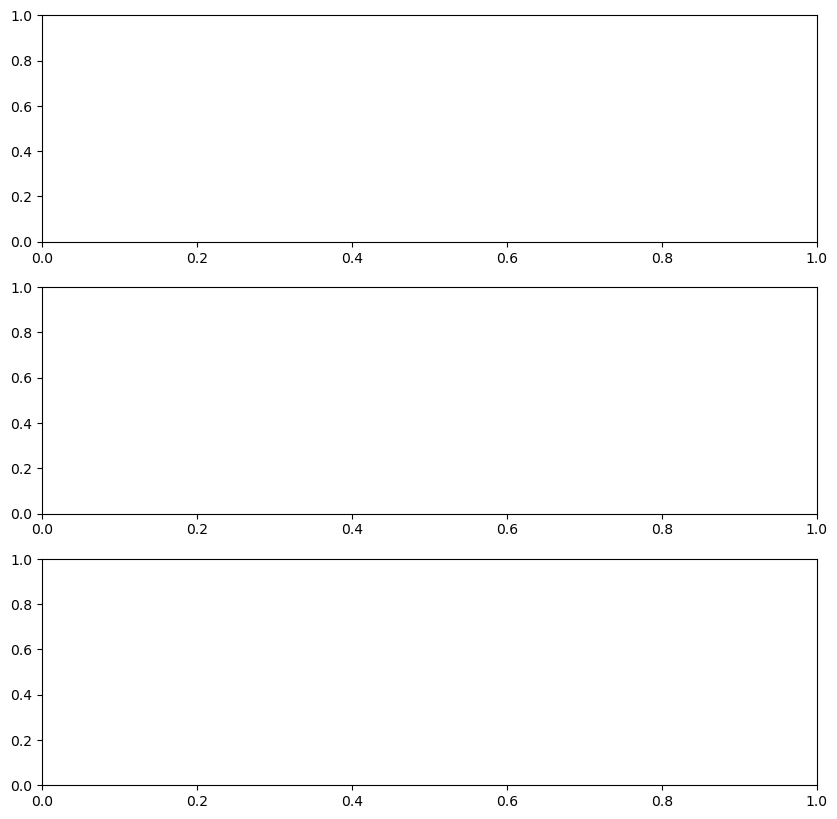

In [97]:
fig, axs = plt.subplots(3, figsize=(10,10))

for month_number in [0, 1, 2]:

    fns = glob('/Volumes/seagate_desktop/em_real/em_real_winter_1_sfcinput/wrfout_d03_2015-0' + str(month_number + 1) + '*')
    wrflist = list()
    for fn in fns:
        wrflist.append(Dataset(fn))
    cldfra = getvar(wrflist, "CLDFRA", timeidx=ALL_TIMES, method="cat").max('bottom_top')
    lats, lons = latlon_coords(cldfra)
    cart_proj = get_cartopy(getvar(wrflist, 'CLDFRA'))
    ax = axs[month_number].axes(projection=cart_proj)

    states = NaturalEarthFeature(category="cultural", 
                                 scale="50m",
                                 facecolor="none",
                                 name="admin_1_states_provinces_shp")
    ax.coastlines('50m', linewidth=0.8)
    ax.contourf(lons.values, lats.values, cldfra_mod.mean('Time').values, [0, 0.25, 0.5, 0.75, 1], transform=crs.PlateCarree())

plt.tight_layout()
plt.show()

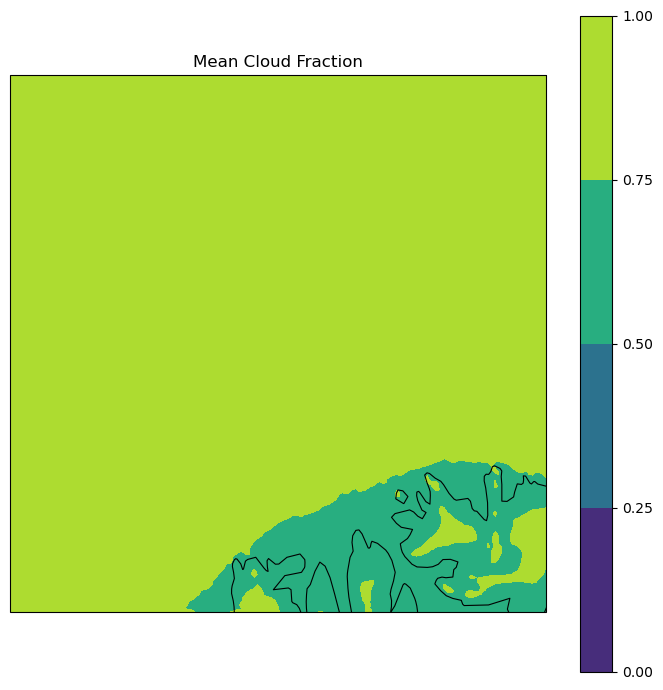

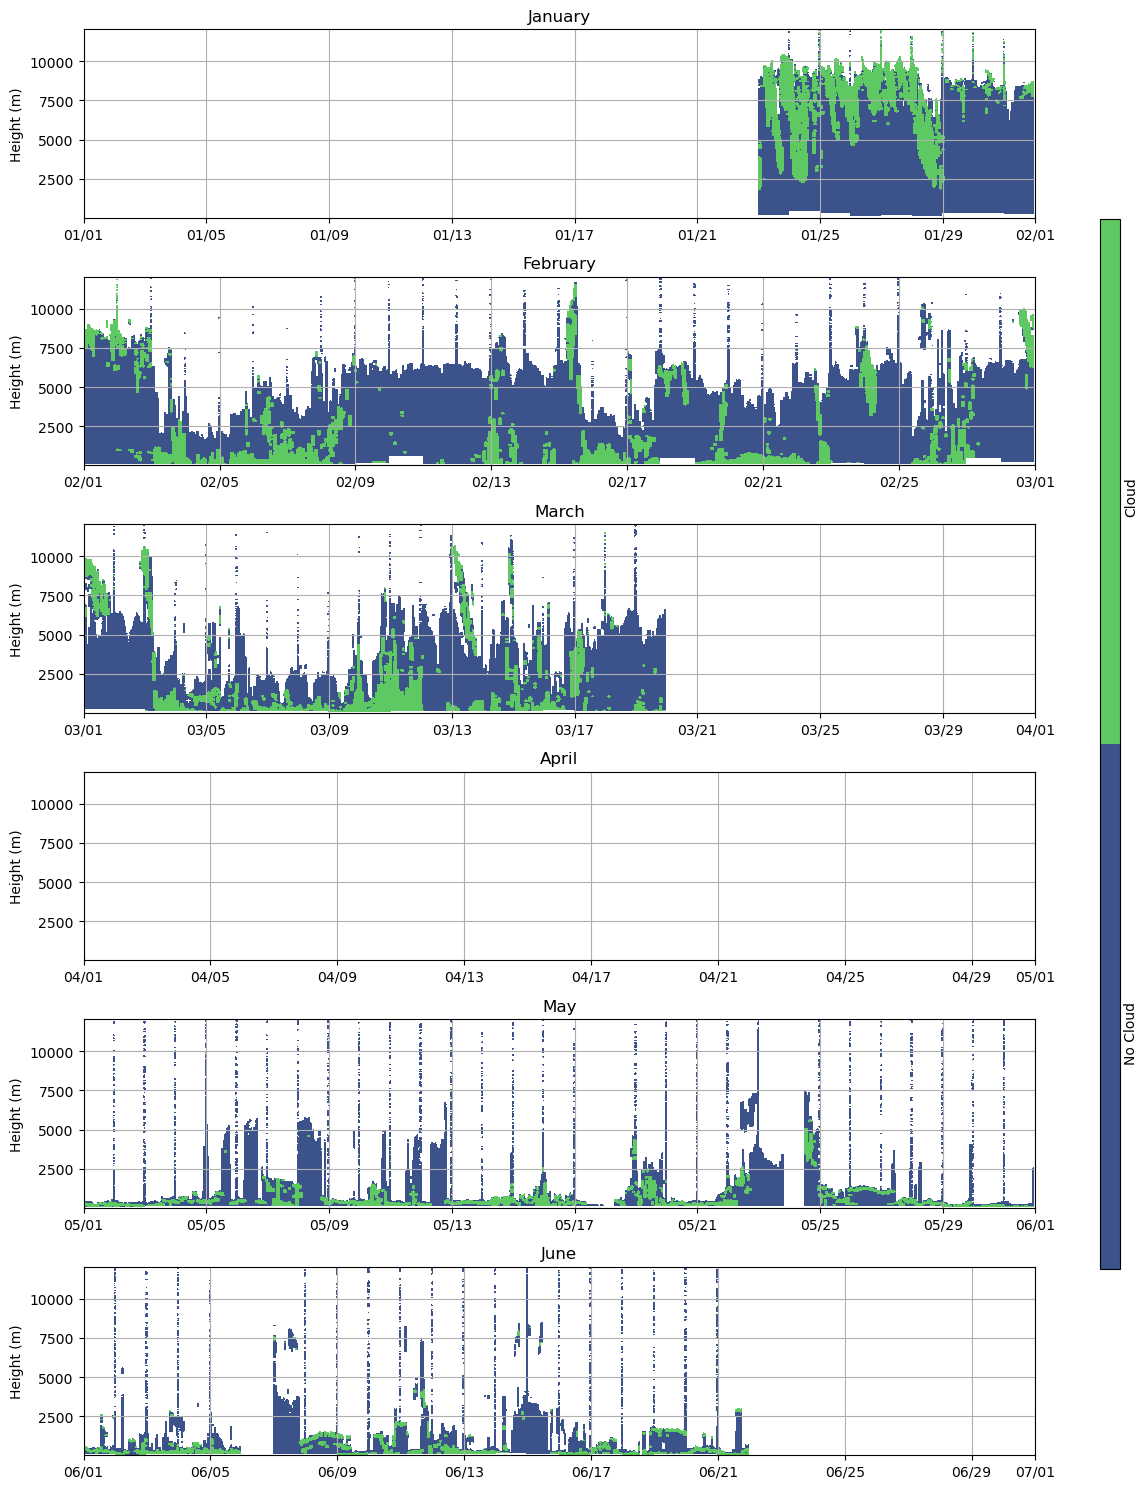

In [55]:
fig, axs = plt.subplots(6, figsize=(13,15))

for month_number in [0, 1, 2, 3, 4, 5]:
    goal_dates = pd.date_range('2015-' + str(month_number+1) + '-01 00:00:00', '2015-' + str(month_number+2) + '-01 00:00:00', freq='H')
    measured_cloudmask_all = pd.DataFrame()
    fns = glob('/Volumes/seagate_desktop/data/MPL/Robert_MPLData/FinalNICELidarData/NICE_MPLDataFinal20150' + str(month_number+1) + '*')
    for fn in fns:
        rbt_cldmask = xr.open_dataset(fn)
        # Time is in UTC time stamp in fractional hours
        Time = rbt_cldmask.variables['DataTime'].values
        # Fix time to be a timestamp - Currently in hours
        yy = 2015
        mm = int(fn[-8:-6])
        dd = int(fn[-6:-4])
        date = [datetime(yy,mm,dd) + timedelta(seconds=hr*3600) for hr in Time[~np.isnan(Time)]]
        
        measured_cloudmask = pd.DataFrame(rbt_cldmask['CloudMask'][~np.isnan(Time)].values, 
                                          index = date, 
                                          columns = rbt_cldmask['Range'])
        measured_cloudmask_all = pd.concat([measured_cloudmask_all, measured_cloudmask])
     
    
    df = pd.DataFrame(np.zeros(len(goal_dates)), index=goal_dates)
    df.columns = ['zeros']
    measured_cloudmask_all = pd.concat([measured_cloudmask_all, df])
    measured_cloudmask_all = measured_cloudmask_all.resample('1h').first()
    del measured_cloudmask_all['zeros']
    axs[month_number].grid()
    heatmap = axs[month_number].contourf(measured_cloudmask_all.index,
                                         measured_cloudmask_all.columns, 
                                         measured_cloudmask_all.T.values,
                                         levels = [-1, 0, 1])
    # nan - no information
    # 1 - cloud 
    # 0 - clear
    axs[month_number].set_title(date[0].strftime("%B"))
    axs[month_number].set_ylabel('Height (m)')
    axs[month_number].xaxis.set_major_formatter(myFmt)

plt.tight_layout()
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.015, 0.7])
cbar = fig.colorbar(heatmap,ticks = [-0.5, 0.5], orientation = 'vertical', cax=cbar_ax)
cbar.ax.set_yticklabels(['No Cloud', 'Cloud'], rotation = 90)
cbar.ax.tick_params(size=0)
plt.show()

### In the surrounding area
#### Mean monthly

#### Mean Seasonal

# Spring

## Sensible and Latent Heat Flux

## Longwave and Shortwave Radiation

## Cloud Cover
### Above N-ICE

### In the surrounding area
#### Mean monthly

#### Mean Seasonal

# Summary